### This script shows a basic example of training a SentenceTransformer multimodal model with omics data stored in anndata format

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from mmcontext.utils import setup_logging

setup_logging()

<RootLogger root (INFO)>

In [16]:
from mmcontext.models import MMContextEncoder

model = MMContextEncoder(
    text_encoder_name="pritamdeka/S-BioBert-snli-multinli-stsb",
    omics_input_dim=64,
    processor_obsm_key="X_scvi",
    freeze_text_encoder=True,
    unfreeze_last_n_layers=0,
)

loading configuration file config.json from cache at /Users/mengerj/.cache/huggingface/hub/models--pritamdeka--S-BioBert-snli-multinli-stsb/snapshots/21e0a553d5ef08802bacbd8331dfb93b5299c151/config.json
Model config BertConfig {
  "_name_or_path": "pritamdeka/S-BioBert-snli-multinli-stsb",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.43.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file pytorch_model.bin from cache at /Users/mengerj/.cache/huggingface/hub/models--pritamdeka--S-BioBert

In [17]:
from sentence_transformers import SentenceTransformer

modules = [model]
model = SentenceTransformer(modules=modules)

2025-02-14 08:54:45,338 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps


In [18]:
from datasets import load_dataset

dataset_name = "geo_7k_cellxgene_3_5k_pairs"
dataset = load_dataset(f"jo-mengr/{dataset_name}")
# test_dataset = load_dataset("jo-mengr/human_pancreas_norm_complexBatch_single")

In [19]:
from datasets import load_dataset
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerModelCardData,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)
from sentence_transformers.evaluation import BinaryClassificationEvaluator
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers

# 3. Load a dataset to finetune on
train_dataset = dataset["train"]
eval_dataset = dataset["val"]
# test_dataset = test_dataset["train"]

# 4. Define a loss function
loss = losses.ContrastiveLoss(model=model)

# 5. (Optional) Specify training arguments
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="../../data/models/mmcontext_trained",
    # Optional training parameters:
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    # batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name="mmcontext",  # Will be used in W&B if `wandb` is installed
)

# 6. (Optional) Create an evaluator & evaluate the base model
dev_evaluator = BinaryClassificationEvaluator(
    sentences1=eval_dataset["anndata_ref"],
    sentences2=eval_dataset["caption"],
    labels=eval_dataset["label"],
)
dev_evaluator(model)

# 7. Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=dev_evaluator,
    extra_feature_keys=["omics_representation"],
)
trainer.train()

## (Optional) Evaluate the trained model on the test set
# test_evaluator = TripletEvaluator(
#    anchors=test_dataset["anchor"],
#    positives=test_dataset["positive"],
#    negatives=test_dataset["negative"],
#    name="all-nli-test",
# )
# test_evaluator(model)

## 8. Save the trained model
# model.save_pretrained("models/mpnet-base-all-nli-triplet/final")

# 9. (Optional) Push it to the Hugging Face Hub
# model.push_to_hub("mpnet-base-all-nli-triplet")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
2025-02-14 08:54:53,433 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset:
2025-02-14 08:54:54,759 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             67.33	(Threshold: 0.0282)
2025-02-14 08:54:54,759 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   50.04	(Threshold: -0.0337)
2025-02-14 08:54:54,759 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            33.37
2025-02-14 08:54:54,760 - sentence_transformers.evaluation.Bi

{'loss': 0.1414, 'grad_norm': 0.5147718787193298, 'learning_rate': 1.849340866290019e-05, 'epoch': 0.17}























2025-02-14 08:55:07,096 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.1692047377326565 after 100 steps:
2025-02-14 08:55:07,762 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             70.57	(Threshold: 0.3153)
2025-02-14 08:55:07,762 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   58.55	(Threshold: -0.0879)
2025-02-14 08:55:07,763 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            43.07
2025-02-14 08:55:07,763 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               91.43
2025-02-14 08:55:07,763 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    

{'eval_loss': 0.11173465102910995, 'eval_cosine_accuracy': 0.7057142857142857, 'eval_cosine_accuracy_threshold': 0.3152807056903839, 'eval_cosine_f1': 0.585544373284538, 'eval_cosine_f1_threshold': -0.0878860354423523, 'eval_cosine_precision': 0.4306864064602961, 'eval_cosine_recall': 0.9142857142857143, 'eval_cosine_ap': 0.5483566821227801, 'eval_cosine_mcc': 0.3212781137792789, 'eval_runtime': 3.4639, 'eval_samples_per_second': 303.124, 'eval_steps_per_second': 19.054, 'epoch': 0.17}


Deleting older checkpoint [../../data/models/mmcontext_trained/checkpoint-100] due to args.save_total_limit
                                                 
 37%|███▋      | 217/591 [05:24<00:54,  6.85it/s]
***** Running Evaluation *****
  Num examples = 1050
  Batch size = 16


{'loss': 0.1057, 'grad_norm': 0.16390712559223175, 'learning_rate': 1.4726930320150661e-05, 'epoch': 0.34}





















2025-02-14 08:55:19,567 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.338409475465313 after 200 steps:
2025-02-14 08:55:20,112 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             71.90	(Threshold: 0.5013)
2025-02-14 08:55:20,112 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   60.00	(Threshold: 0.1696)
2025-02-14 08:55:20,112 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            51.00
2025-02-14 08:55:20,112 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               72.86
2025-02-14 08:55:20,113 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    57.7

{'eval_loss': 0.08542081713676453, 'eval_cosine_accuracy': 0.719047619047619, 'eval_cosine_accuracy_threshold': 0.5013283491134644, 'eval_cosine_f1': 0.6000000000000001, 'eval_cosine_f1_threshold': 0.16961562633514404, 'eval_cosine_precision': 0.51, 'eval_cosine_recall': 0.7285714285714285, 'eval_cosine_ap': 0.5775410805462621, 'eval_cosine_mcc': 0.3573259271055183, 'eval_runtime': 3.392, 'eval_samples_per_second': 309.555, 'eval_steps_per_second': 19.458, 'epoch': 0.34}


Deleting older checkpoint [../../data/models/mmcontext_trained/checkpoint-200] due to args.save_total_limit
                                                 
 37%|███▋      | 217/591 [05:36<00:54,  6.85it/s]
***** Running Evaluation *****
  Num examples = 1050
  Batch size = 16


{'loss': 0.0878, 'grad_norm': 0.41362264752388, 'learning_rate': 1.096045197740113e-05, 'epoch': 0.51}





















2025-02-14 08:55:31,530 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.5076142131979695 after 300 steps:
2025-02-14 08:55:32,120 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             72.10	(Threshold: 0.5049)
2025-02-14 08:55:32,121 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   60.71	(Threshold: 0.2222)
2025-02-14 08:55:32,121 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            51.60
2025-02-14 08:55:32,121 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               73.71
2025-02-14 08:55:32,121 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    58.

{'eval_loss': 0.07549683749675751, 'eval_cosine_accuracy': 0.7209523809523809, 'eval_cosine_accuracy_threshold': 0.5048542022705078, 'eval_cosine_f1': 0.6070588235294118, 'eval_cosine_f1_threshold': 0.22220036387443542, 'eval_cosine_precision': 0.516, 'eval_cosine_recall': 0.7371428571428571, 'eval_cosine_ap': 0.5843134069149037, 'eval_cosine_mcc': 0.36946152462985665, 'eval_runtime': 3.4609, 'eval_samples_per_second': 303.389, 'eval_steps_per_second': 19.07, 'epoch': 0.51}


Deleting older checkpoint [../../data/models/mmcontext_trained/checkpoint-300] due to args.save_total_limit
                                                 
 37%|███▋      | 217/591 [05:48<00:54,  6.85it/s]
***** Running Evaluation *****
  Num examples = 1050
  Batch size = 16


{'loss': 0.0849, 'grad_norm': 0.33931219577789307, 'learning_rate': 7.193973634651601e-06, 'epoch': 0.68}






















2025-02-14 08:55:43,712 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.676818950930626 after 400 steps:
2025-02-14 08:55:44,274 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             72.48	(Threshold: 0.4736)
2025-02-14 08:55:44,274 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   61.52	(Threshold: 0.2607)
2025-02-14 08:55:44,274 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            52.64
2025-02-14 08:55:44,274 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               74.00
2025-02-14 08:55:44,275 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    59.

{'eval_loss': 0.06996359676122665, 'eval_cosine_accuracy': 0.7247619047619047, 'eval_cosine_accuracy_threshold': 0.4735688269138336, 'eval_cosine_f1': 0.6152019002375296, 'eval_cosine_f1_threshold': 0.26072582602500916, 'eval_cosine_precision': 0.5264227642276422, 'eval_cosine_recall': 0.74, 'eval_cosine_ap': 0.5951622286735352, 'eval_cosine_mcc': 0.38461853677418795, 'eval_runtime': 3.433, 'eval_samples_per_second': 305.852, 'eval_steps_per_second': 19.225, 'epoch': 0.68}


Deleting older checkpoint [../../data/models/mmcontext_trained/checkpoint-400] due to args.save_total_limit
                                                 
 37%|███▋      | 217/591 [06:00<00:54,  6.85it/s]
***** Running Evaluation *****
  Num examples = 1050
  Batch size = 16


{'loss': 0.0746, 'grad_norm': 0.2509113550186157, 'learning_rate': 3.427495291902072e-06, 'epoch': 0.85}





















2025-02-14 08:55:55,774 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.8460236886632826 after 500 steps:
2025-02-14 08:55:56,352 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             72.86	(Threshold: 0.5500)
2025-02-14 08:55:56,352 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   61.88	(Threshold: 0.1966)
2025-02-14 08:55:56,352 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            49.49
2025-02-14 08:55:56,353 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               82.57
2025-02-14 08:55:56,353 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    60.

{'eval_loss': 0.0615980438888073, 'eval_cosine_accuracy': 0.7285714285714285, 'eval_cosine_accuracy_threshold': 0.5500429272651672, 'eval_cosine_f1': 0.6188436830835118, 'eval_cosine_f1_threshold': 0.19655472040176392, 'eval_cosine_precision': 0.4948630136986301, 'eval_cosine_recall': 0.8257142857142857, 'eval_cosine_ap': 0.6003735193681632, 'eval_cosine_mcc': 0.3835942210555128, 'eval_runtime': 3.495, 'eval_samples_per_second': 300.433, 'eval_steps_per_second': 18.884, 'epoch': 0.85}


Deleting older checkpoint [../../data/models/mmcontext_trained/checkpoint-500] due to args.save_total_limit
2025-02-14 08:56:04,543 - sentence_transformers.trainer - INFO - Saving model checkpoint to ../../data/models/mmcontext_trained/checkpoint-591
2025-02-14 08:56:04,543 - sentence_transformers.SentenceTransformer - INFO - Save model to ../../data/models/mmcontext_trained/checkpoint-591
Deleting older checkpoint [../../data/models/mmcontext_trained/checkpoint-591] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


                                                 
100%|██████████| 591/591 [01:06<00:00,  8.89it/s]

{'train_runtime': 66.5159, 'train_samples_per_second': 142.071, 'train_steps_per_second': 8.885, 'train_loss': 0.0951456684751559, 'epoch': 1.0}


TrainOutput(global_step=591, training_loss=0.0951456684751559, metrics={'train_runtime': 66.5159, 'train_samples_per_second': 142.071, 'train_steps_per_second': 8.885, 'total_flos': 0.0, 'train_loss': 0.0951456684751559, 'epoch': 1.0})

In [39]:
model[0].processor.omics_processor.clear_cache()

In [32]:
model.push_to_hub(repo_id="jo-mengr/mmcontext")

2025-02-13 11:31:53,117 - sentence_transformers.SentenceTransformer - INFO - Save model to /var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/tmp08xf8b8c
model.safetensors: 100%|██████████| 434M/434M [00:28<00:00, 15.2MB/s] 


'https://huggingface.co/jo-mengr/mmcontext/commit/18aee6c278164ddd14bbbe0a3d5a0230cb93b7f7'

In [40]:
from datasets import load_dataset

test_dataset = load_dataset("jo-mengr/bowel_disease_single")["train"]

In [41]:
embeddings = model.encode(test_dataset["anndata_ref"])

Batches: 100%|██████████| 350/350 [00:17<00:00, 20.11it/s]


In [21]:
from mmcontext.utils import load_test_adata_from_hf_dataset

adata = load_test_adata_from_hf_dataset(test_dataset)

2025-02-13 11:13:10,838 - mmcontext.utils - INFO - File is a valid .h5ad file.


In [24]:
# caption embeddings
text_embeddings = model.encode(adata.obs["cluster_label"].values.tolist())

Batches: 100%|██████████| 350/350 [00:05<00:00, 59.92it/s]


In [25]:
adata.obsm["mmcontext_emb"] = embeddings
adata.obsm["mmcontext_text_emb"] = text_embeddings

2025-02-13 11:13:38,290 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-13 11:13:38,291 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Figure size 800x800 with 0 Axes>

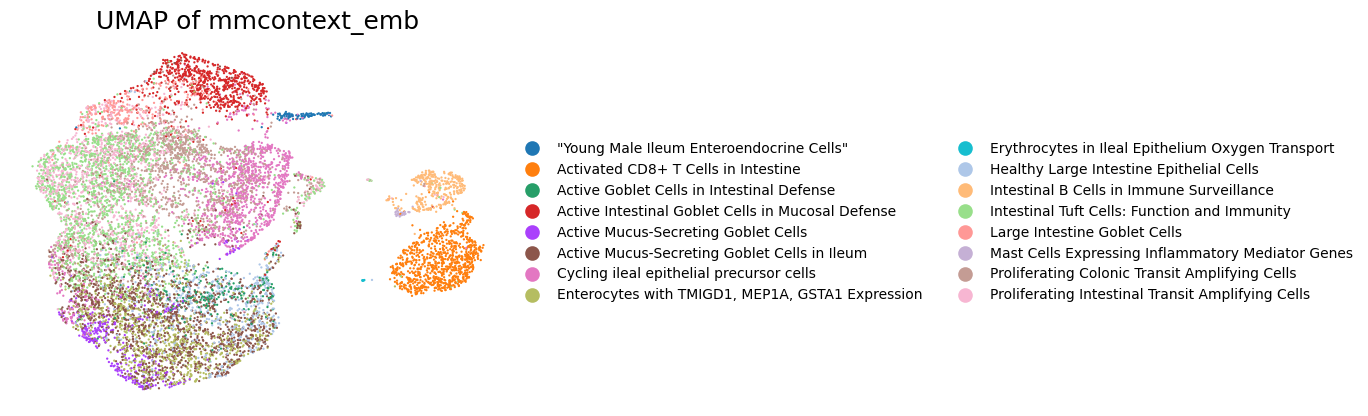

2025-02-13 11:13:50,530 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [23]:
# Visualise the embeddings
from mmcontext.pl import plot_umap

label_key = "cluster_label"
plot_umap(adata, color_key=label_key, embedding_key="mmcontext_emb")

2025-02-13 11:16:51,732 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-13 11:16:51,733 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_text_emb'.


<Figure size 800x800 with 0 Axes>

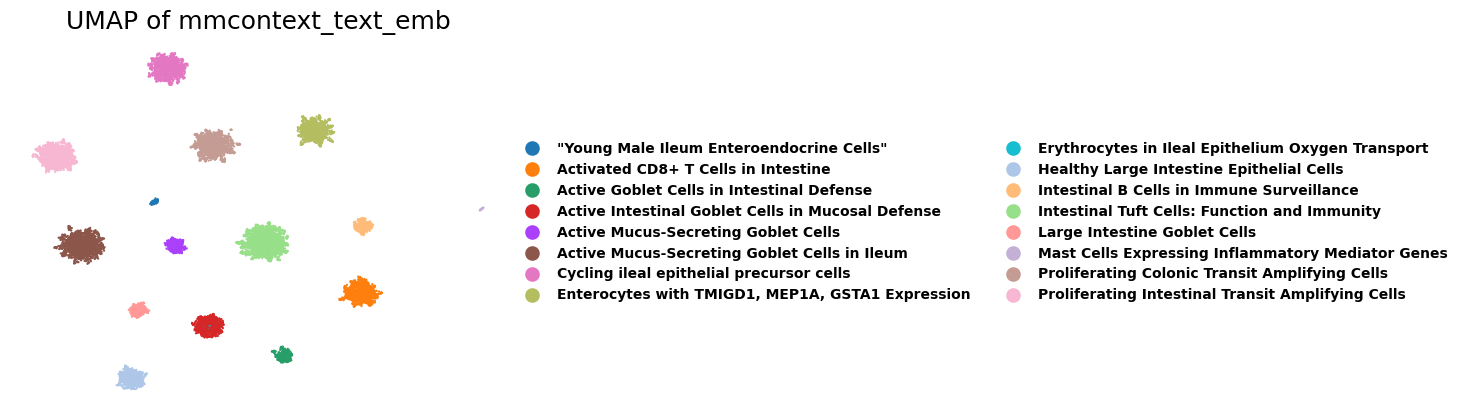

2025-02-13 11:17:00,210 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [26]:
# Visualise the embeddings
from mmcontext.pl import plot_umap

plot_umap(adata, color_key=label_key, embedding_key="mmcontext_text_emb")

In [27]:
labels = adata.obs[label_key].unique().tolist()

In [28]:
from mmcontext.engine import OmicsQueryAnnotator

annotator = OmicsQueryAnnotator(model)
annotator.annotate_omics_data(adata, labels)

2025-02-13 11:18:05,459 - mmcontext.engine.query_annotate - INFO - Using matrix multiplication to compute label similarities.
Batches: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]
2025-02-13 11:18:05,603 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-02-13 11:18:05,603 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-02-13 11:18:05,604 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu


2025-02-13 11:18:09,497 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-13 11:18:09,497 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.
... storing 'best_label' as categorical


<Figure size 800x800 with 0 Axes>

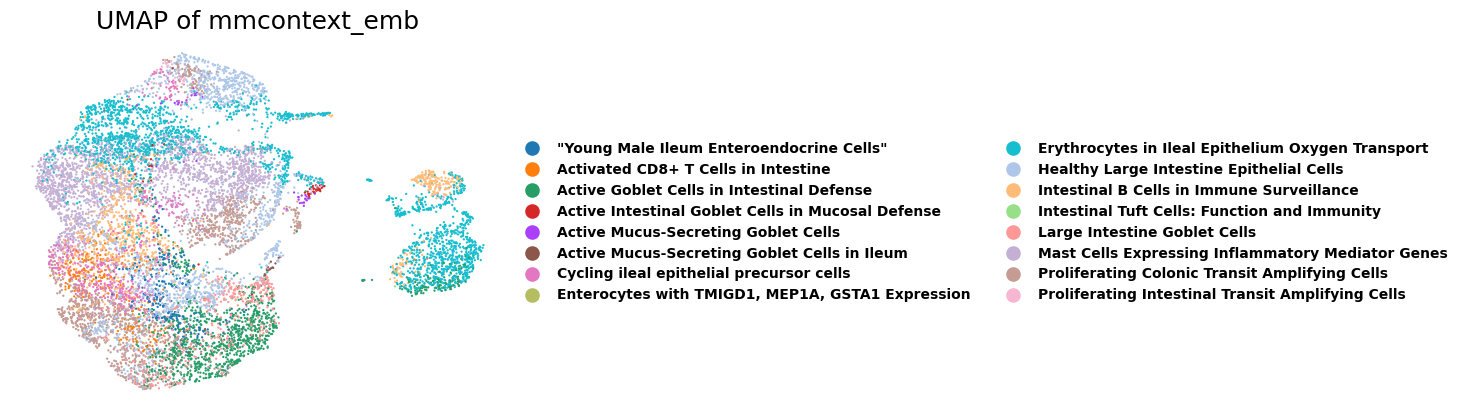

2025-02-13 11:18:13,117 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [29]:
from mmcontext.pl import plot_umap

plot_umap(adata, color_key="best_label", embedding_key="mmcontext_emb")

In [30]:
from mmcontext.eval import evaluate_annotation_accuracy

evaluate_annotation_accuracy(adata, true_key=label_key, inferred_key="best_label")

2025-02-13 11:18:38,032 - mmcontext.eval.annotation_accuracy - INFO - Evaluating annotation accuracy for keys 'cluster_label' and 'best_label'. Accuracy = 4.16%


0.04161073825503356